<h1> Data Preprocessing <h1>

In [152]:
import pandas as pd 
from datetime import datetime
# pd.set_option('display.max_rows',None)

#reading from file
receivedFileName="resale-flat-prices-based-on-registration-date-from-jan-2017-onwards.csv"
resaleFlatDF = pd.read_csv(receivedFileName, encoding = "ISO-8859-1")


# df = pd.DataFrame(data = resaleFlat)


# df = df.sort_values(by=['street_name'])
# df["point_of_interest"] = 0
# df = df.reset_index(drop=True)


type(resaleFlatDF)
resaleFlatDF

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price
0,2017-01,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44.0,Improved,1979,61 years 04 months,232000.0
1,2017-01,ANG MO KIO,3 ROOM,108,ANG MO KIO AVE 4,01 TO 03,67.0,New Generation,1978,60 years 07 months,250000.0
2,2017-01,ANG MO KIO,3 ROOM,602,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,262000.0
3,2017-01,ANG MO KIO,3 ROOM,465,ANG MO KIO AVE 10,04 TO 06,68.0,New Generation,1980,62 years 01 month,265000.0
4,2017-01,ANG MO KIO,3 ROOM,601,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,265000.0
...,...,...,...,...,...,...,...,...,...,...,...
100642,2021-06,YISHUN,5 ROOM,511A,YISHUN ST 51,10 TO 12,113.0,Improved,2017,95 years 03 months,610000.0
100643,2021-06,YISHUN,EXECUTIVE,664,YISHUN AVE 4,01 TO 03,181.0,Apartment,1992,69 years 11 months,868000.0
100644,2021-06,YISHUN,EXECUTIVE,277,YISHUN ST 22,01 TO 03,152.0,Maisonette,1985,63 years 03 months,585000.0
100645,2021-06,YISHUN,EXECUTIVE,643,YISHUN ST 61,01 TO 03,146.0,Maisonette,1987,65 years 04 months,600000.0


<!---
Retrieve accurate year left for remaining_lease based on the year the data is entered
-->

Transforming data to reflect accurate remaining_lease based on our current year instead of previous data.

In [153]:

for i, row in resaleFlatDF.iterrows():
   # datetime_object = datetime(2020, 2 ,2)
    year = int(row["remaining_lease"].split("years")[0])
    startDatetime = datetime.strptime(row["month"], '%Y-%m')
    #get the end date value
    currentDate = datetime.now()
    numberOfYears = (startDatetime.year + year - currentDate.year)
    resaleFlatDF.at[i, 'remaining_lease'] = numberOfYears
resaleFlatDF

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price
0,2017-01,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44.0,Improved,1979,57,232000.0
1,2017-01,ANG MO KIO,3 ROOM,108,ANG MO KIO AVE 4,01 TO 03,67.0,New Generation,1978,56,250000.0
2,2017-01,ANG MO KIO,3 ROOM,602,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,58,262000.0
3,2017-01,ANG MO KIO,3 ROOM,465,ANG MO KIO AVE 10,04 TO 06,68.0,New Generation,1980,58,265000.0
4,2017-01,ANG MO KIO,3 ROOM,601,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,58,265000.0
...,...,...,...,...,...,...,...,...,...,...,...
100642,2021-06,YISHUN,5 ROOM,511A,YISHUN ST 51,10 TO 12,113.0,Improved,2017,95,610000.0
100643,2021-06,YISHUN,EXECUTIVE,664,YISHUN AVE 4,01 TO 03,181.0,Apartment,1992,69,868000.0
100644,2021-06,YISHUN,EXECUTIVE,277,YISHUN ST 22,01 TO 03,152.0,Maisonette,1985,63,585000.0
100645,2021-06,YISHUN,EXECUTIVE,643,YISHUN ST 61,01 TO 03,146.0,Maisonette,1987,65,600000.0


Transformation of data into categories for our algorithm:

Flat type, storey_range and flat model is converted to numerical values for categorisation <br>
Resale price is categorised to intervals of \$100,000 or bigger than \$1,000,000 <br>
Remaining lease is categorised to intervals of decades <br>

In [154]:
import math
#price is sorted to intervals of every 100000, when above 1000000, displayed as above 1000000
flatType = sorted(resaleFlatDF["flat_type"].drop_duplicates())
flatType
i = 1 
for x in flatType:
    resaleFlatDF["flat_type"] = resaleFlatDF["flat_type"].replace([x],i)
    i = i + 1   

storeyRange = sorted(resaleFlatDF["storey_range"].drop_duplicates())
storeyRange
i = 1 
for x in storeyRange:
    resaleFlatDF["storey_range"] = resaleFlatDF["storey_range"].replace([x],i)
    i = i + 1 
    
flatModel = sorted(resaleFlatDF["flat_model"].drop_duplicates())
flatModel
i = 1 
for x in flatModel:
    resaleFlatDF["flat_model"] = resaleFlatDF["flat_model"].replace([x],i)
    i = i + 1   
#price categorise
resaleFlatDF['resale_price'] = resaleFlatDF['resale_price'].apply(lambda x: math.ceil(x/100000) if x < 1000000 else 11)

#remaining lease categorise
resaleFlatDF['remaining_lease'] = resaleFlatDF['remaining_lease'].apply(lambda x: math.ceil(x/10))
resaleFlatDF

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price
0,2017-01,ANG MO KIO,2,406,ANG MO KIO AVE 10,4,44.0,5,1979,6,3
1,2017-01,ANG MO KIO,3,108,ANG MO KIO AVE 4,1,67.0,12,1978,6,3
2,2017-01,ANG MO KIO,3,602,ANG MO KIO AVE 5,1,67.0,12,1980,6,3
3,2017-01,ANG MO KIO,3,465,ANG MO KIO AVE 10,2,68.0,12,1980,6,3
4,2017-01,ANG MO KIO,3,601,ANG MO KIO AVE 5,1,67.0,12,1980,6,3
...,...,...,...,...,...,...,...,...,...,...,...
100642,2021-06,YISHUN,5,511A,YISHUN ST 51,4,113.0,5,2017,10,7
100643,2021-06,YISHUN,6,664,YISHUN AVE 4,1,181.0,3,1992,7,9
100644,2021-06,YISHUN,6,277,YISHUN ST 22,1,152.0,7,1985,7,6
100645,2021-06,YISHUN,6,643,YISHUN ST 61,1,146.0,7,1987,7,6


Dropping data that does not help define the flat or is unnecessary:

All these variables does not define the flat <br>
Except for floor_area_sqm which is based on the flat type. Hence it is redundant

In [155]:
resaleFlatDF = resaleFlatDF.drop(['month','town','block','floor_area_sqm','street_name','lease_commence_date'], axis=1)
resaleFlatDF

,flat_type,storey_range,flat_model,remaining_lease,resale_price
0,2,4,5,6,3
1,3,1,12,6,3
2,3,1,12,6,3
3,3,2,12,6,3
4,3,1,12,6,3
...,...,...,...,...,...
100642,5,4,5,10,7
100643,6,1,3,7,9
100644,6,1,7,7,6
100645,6,1,7,7,6


Adding classes onto data for hierarchical clustering to transform into training data

In [156]:
resaleFlatGroupDF = resaleFlatDF.groupby(["flat_type","storey_range","flat_model","remaining_lease","resale_price"])
resaleFlatDF["Class"] = 0
category = pd.DataFrame(columns=["flat_type","storey_range","flat_model","remaining_lease","resale_price","Class"])

for i, (key, df) in enumerate(resaleFlatGroupDF):
    category = category.append({"flat_type": key[0],"storey_range": key[1],"flat_model": key[2],"remaining_lease": key[3],"resale_price": key[4], "Class": i}, ignore_index = True)
    for row in df.iterrows():
        resaleFlatDF.loc[row[0], 'Class'] = i
print(category)
resaleFlatDF


     flat_type storey_range flat_model remaining_lease resale_price Class
0            1            1          5               6            2     0
1            1            1          5               6            3     1
2            1            2          5               6            2     2
3            1            2          5               6            3     3
4            1            3          5               6            2     4
...        ...          ...        ...             ...          ...   ...
2470         7            3         11               7            9  2470
2471         7            4         11               7            7  2471
2472         7            4         11               7            8  2472
2473         7            4         11               7            9  2473
2474         7            4         11               7           10  2474

[2475 rows x 6 columns]


,flat_type,storey_range,flat_model,remaining_lease,resale_price,Class
0,2,4,5,6,3,87
1,3,1,12,6,3,170
2,3,1,12,6,3,170
3,3,2,12,6,3,242
4,3,1,12,6,3,170
...,...,...,...,...,...,...
100642,5,4,5,10,7,1734
100643,6,1,3,7,9,2224
100644,6,1,7,7,6,2235
100645,6,1,7,7,6,2235


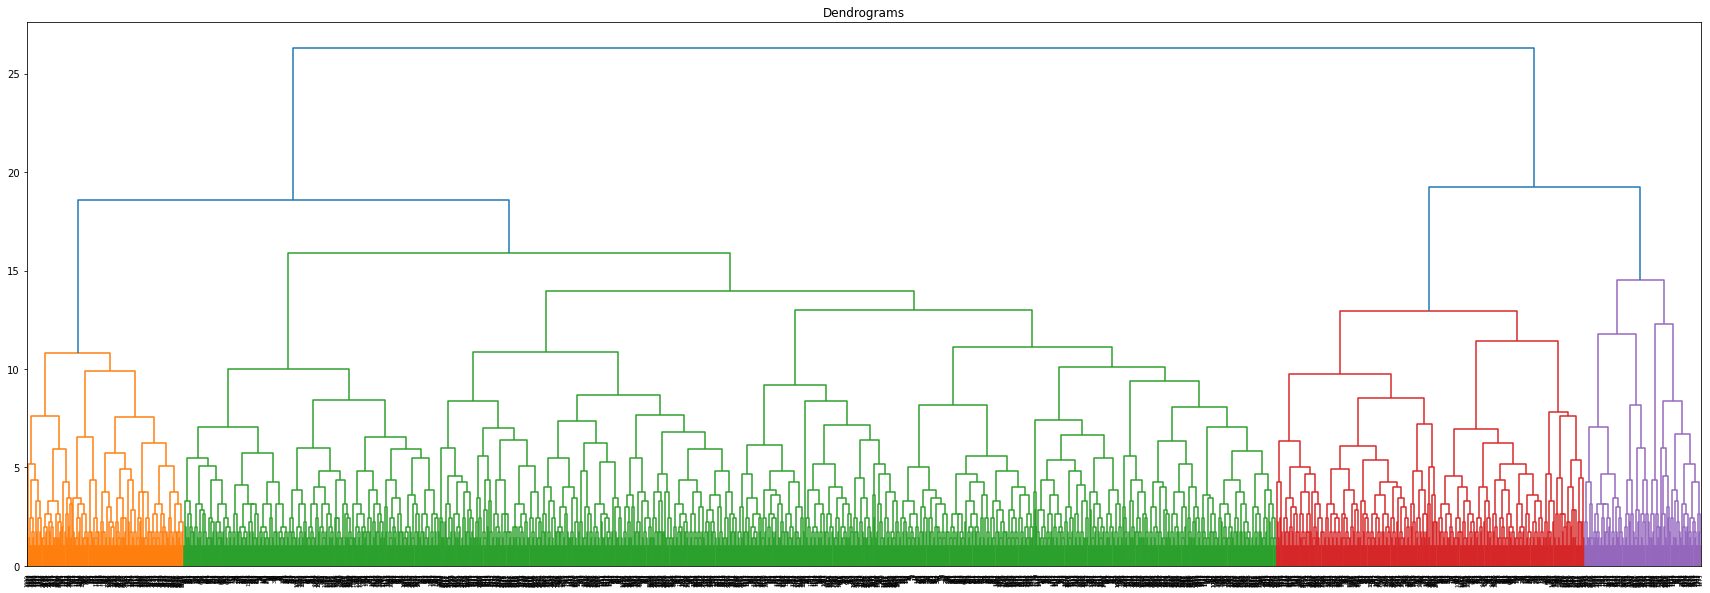

In [157]:
from scipy.cluster import hierarchy
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(30,10)) 
plt.title("Dendrograms")  
names = category['Class']
Y = category['Class']
X = category.iloc[:,[0,1,2,3,4]].values
Z = hierarchy.linkage(X, 'complete')
dn = hierarchy.dendrogram(Z,labels=names.tolist())

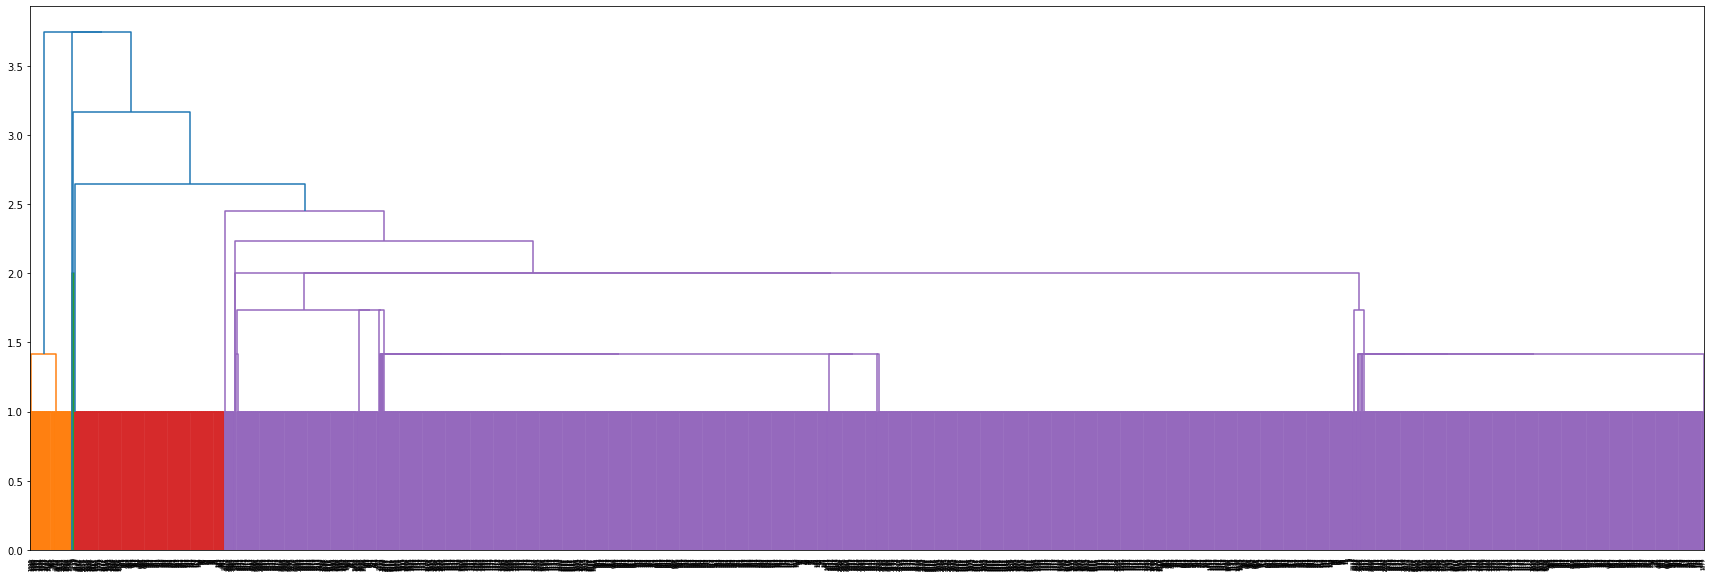

In [158]:
plt.figure(figsize=(30,10)) 
Z = hierarchy.linkage(X, 'single')
dn = hierarchy.dendrogram(Z,labels=names.tolist())

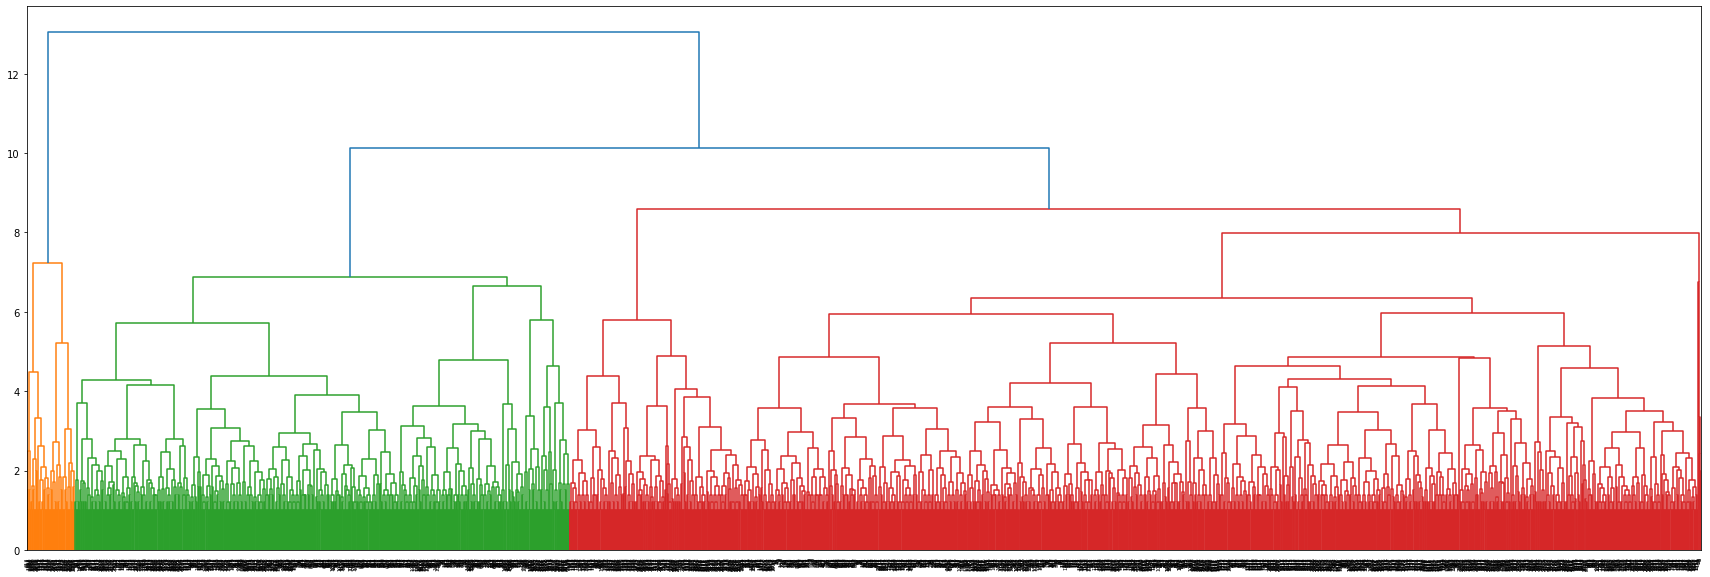

In [159]:
plt.figure(figsize=(30,10)) 
Z = hierarchy.linkage(X, 'average')
dn = hierarchy.dendrogram(Z,labels=names.tolist())

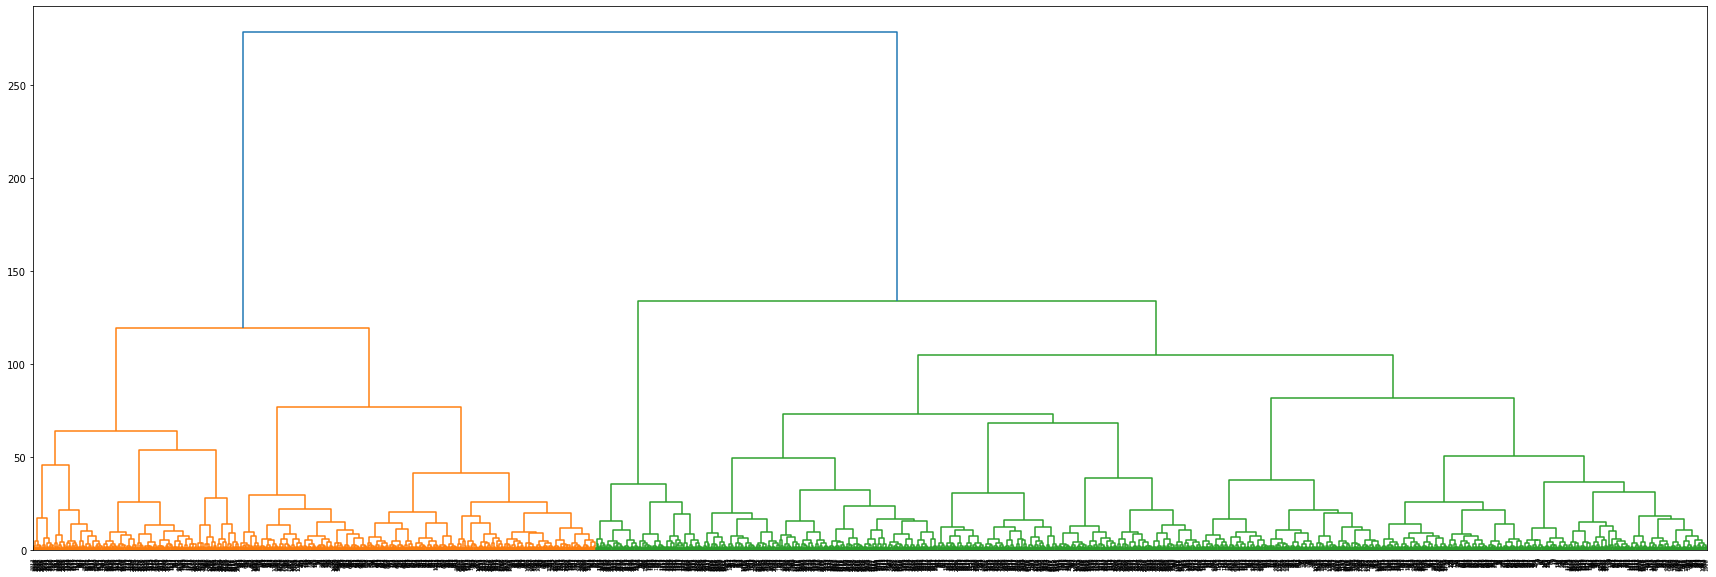

In [160]:
plt.figure(figsize=(30,10)) 
Z = hierarchy.linkage(X, 'ward')
dn = hierarchy.dendrogram(Z,labels=names.tolist())

<h1> @Qi Rong can explain here why we choose complete and below i plot a line "The vertical line with maximum distance is the most left blue line and hence we can decide a threshold of 17 and cut the dendrogram" </h1>

From here on, based on visualization and analysis, we chose complete linkage for our hierarchical clustering. The complete clustering shows on the dendogram to have distinct clusterings compared to single link and ward link. We do not want to have clustering that are close together if not categorization of new data may be biased.

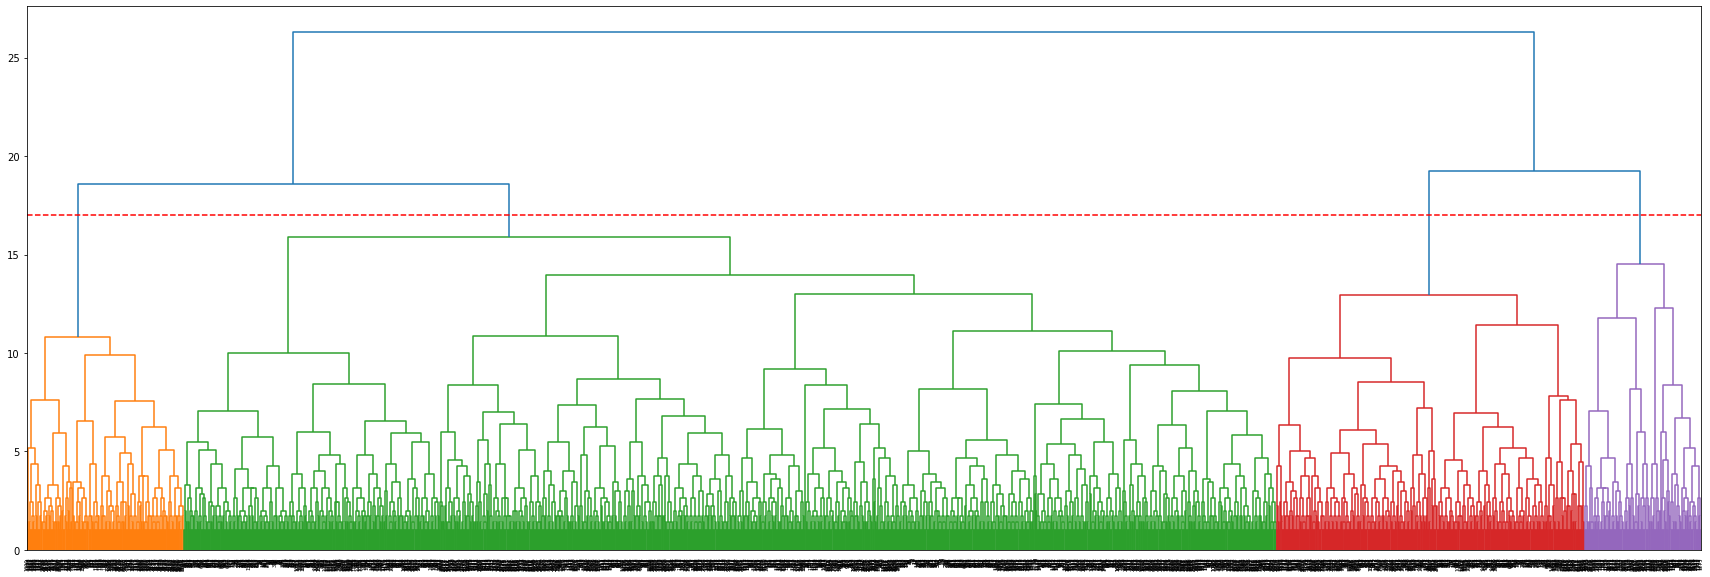

In [161]:
plt.figure(figsize=(30,10)) 
Z = hierarchy.linkage(X, 'complete')
dn = hierarchy.dendrogram(Z,labels=names.tolist())
plt.axhline(y=17, color='r', linestyle='--')

<H1> @Kwang The data got 5 variables, Im not too sure which variables to use and how we should plot it.<H1>

In [162]:
print(category)

     flat_type storey_range flat_model remaining_lease resale_price Class
0            1            1          5               6            2     0
1            1            1          5               6            3     1
2            1            2          5               6            2     2
3            1            2          5               6            3     3
4            1            3          5               6            2     4
...        ...          ...        ...             ...          ...   ...
2470         7            3         11               7            9  2470
2471         7            4         11               7            7  2471
2472         7            4         11               7            8  2472
2473         7            4         11               7            9  2473
2474         7            4         11               7           10  2474

[2475 rows x 6 columns]


[0.50908258 0.30926536 0.11667299 0.04871288 0.01626619]


Text(0.5, 1.0, 'Plot of eigen variance energy captured by Principle component')

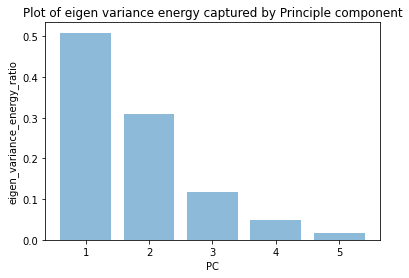

In [171]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA

# 4 clusters because of cut line from above hierarchical dendogram.
cluster = AgglomerativeClustering(n_clusters=4, affinity='manhattan', linkage='complete')
hc = cluster.fit_predict(X)

reds = hc == 0 #label
yellow = hc == 1
blue = hc == 2
magenta = hc == 3

#show all the eigen vector
pca_all = PCA()
pca_all.fit(X)

eigen_energy = pca_all.explained_variance_ratio_ 
print(eigen_energy) #show all the eigen vector
plt.bar(range(1,6),eigen_energy,alpha=0.5,align = 'center',label = 'individual explained variance')
plt.xlabel('PC')
plt.ylabel('eigen_variance_energy_ratio')
plt.title ("Plot of eigen variance energy captured by Principle component")



[[-3.17971576 -5.94328933]
 [-3.25272505 -5.56341454]
 [-3.19485321 -5.04232011]
 ...
 [ 1.96965771 -0.2363515 ]
 [ 1.89664843  0.14352329]
 [ 1.82363915  0.52339809]]
(2475, 2)


Text(0.5, 1.0, 'Projection of Data in Eigenspace')

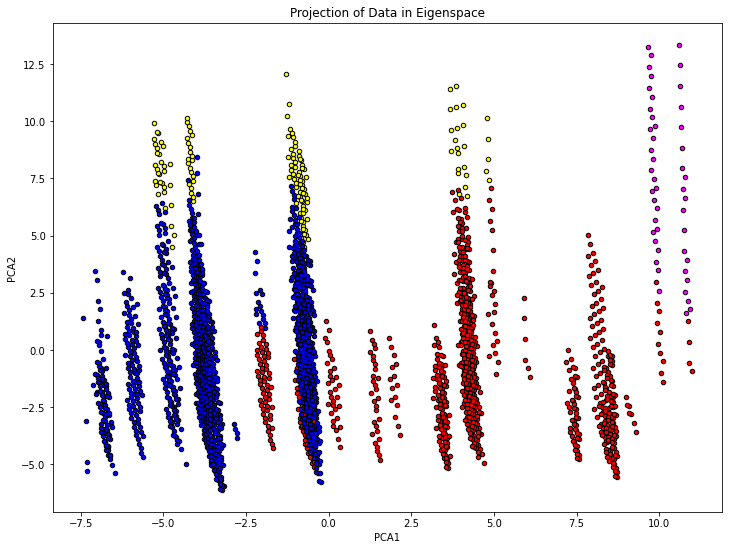

In [173]:
#minimum varaince must be more than 70
pca_2 = PCA (n_components = 2)
pca_2.fit(X)
X_pca_2 = pca_2.transform(X) #transform  become 1000 *2
print(X_pca_2)
print(X_pca_2.shape)

plt.figure(figsize=(12,9)) 

#select the two pc that added up to 80%
plt.scatter(X_pca_2[reds, 0], X_pca_2[reds,1], c="red",s=20,edgecolor = 'k')
plt.scatter(X_pca_2[black,0], X_pca_2[black,1],c="yellow", s=20,edgecolor = 'k')
plt.scatter(X_pca_2[blue,0], X_pca_2[blue,1],c="blue", s=20,edgecolor = 'k')
plt.scatter(X_pca_2[purple,0], X_pca_2[purple,1],c="magenta", s=20,edgecolor = 'k')

plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.title('Projection of Data in Eigenspace')


Text(0.5, 1.0, 'Projection of Data in Eigenspace')

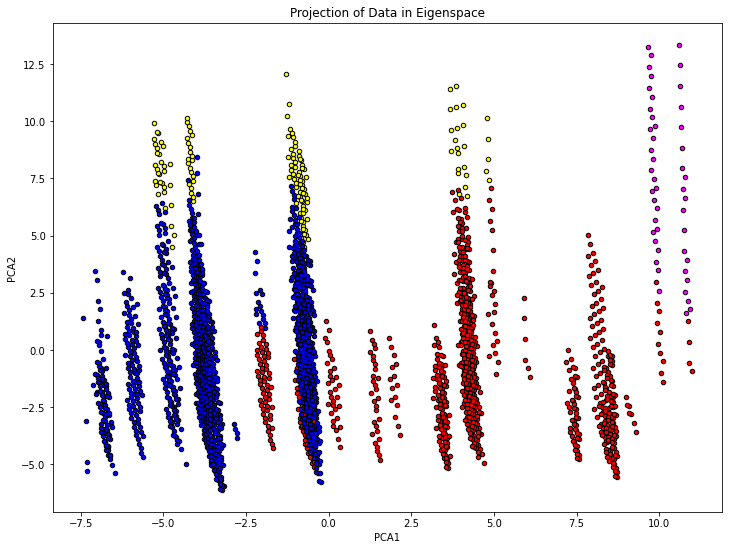

In [174]:
cluster = AgglomerativeClustering(n_clusters=4, affinity='cosine', linkage='complete')  
hc = cluster.fit_predict(X)
reds = hc == 0 #label
yellow = hc == 1
blue = hc == 2
magenta = hc == 3

plt.figure(figsize=(12,9)) 


#select the two pc that added up to 80%
plt.scatter(X_pca_2[reds, 0], X_pca_2[reds,1], c="red",s=20,edgecolor = 'k')
plt.scatter(X_pca_2[black,0], X_pca_2[black,1],c="yellow", s=20,edgecolor = 'k')
plt.scatter(X_pca_2[blue,0], X_pca_2[blue,1],c="blue", s=20,edgecolor = 'k')
plt.scatter(X_pca_2[purple,0], X_pca_2[purple,1],c="magenta", s=20,edgecolor = 'k')



plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.title('Projection of Data in Eigenspace')



Text(0.5, 1.0, 'Projection of Data in Eigenspace')

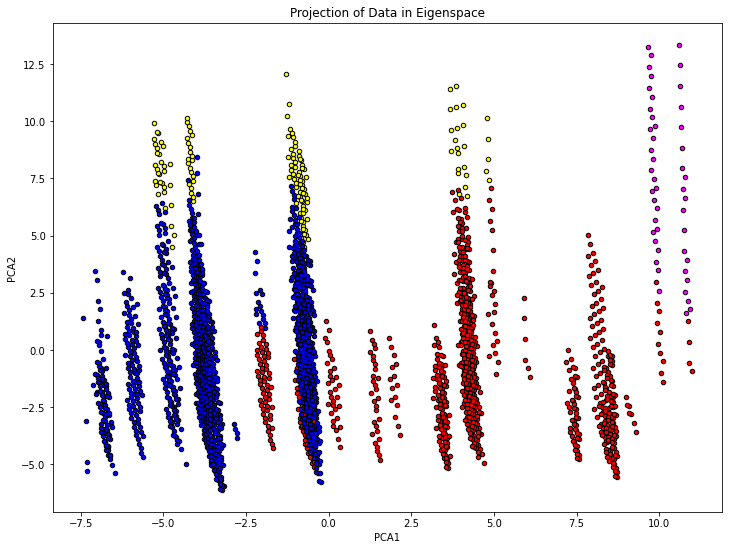

In [175]:
cluster = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='complete')  
hc = cluster.fit_predict(X)
plt.figure(figsize=(12,9)) 


#select the two pc that added up to 80%
plt.scatter(X_pca_2[reds, 0], X_pca_2[reds,1], c="red",s=20,edgecolor = 'k')
plt.scatter(X_pca_2[black,0], X_pca_2[black,1],c="yellow", s=20,edgecolor = 'k')
plt.scatter(X_pca_2[blue,0], X_pca_2[blue,1],c="blue", s=20,edgecolor = 'k')
plt.scatter(X_pca_2[purple,0], X_pca_2[purple,1],c="magenta", s=20,edgecolor = 'k')



plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.title('Projection of Data in Eigenspace')


In [ ]:
cluster = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='complete')
cluster.fit_predict(X)

array([0, 0, 0, ..., 2, 2, 2], dtype=int64)

In [ ]:
cluster = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='complete')
hc = cluster.fit_predict(X)
category['Label'] = hc

# trained data after inserting label col
category

,flat_type,storey_range,flat_model,remaining_lease,resale_price,Class,Label
0,1,1,5,6,2,0,0
1,1,1,5,6,3,1,0
2,1,2,5,6,2,2,0
3,1,2,5,6,3,3,0
4,1,3,5,6,2,4,0
...,...,...,...,...,...,...,...
2470,7,3,11,7,9,2470,2
2471,7,4,11,7,7,2471,2
2472,7,4,11,7,8,2472,2
2473,7,4,11,7,9,2473,2


<h1> KNN / DECISION TREE to find the cluster it belongs to </h1>

In [ ]:
###########################################################
# Create the Training and Test set with split 70:30 
##########################################################

from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, hc, test_size=0.3, random_state=12)
from sklearn import tree
from sklearn.metrics import accuracy_score


Text(0, 0.5, 'Accuracy')

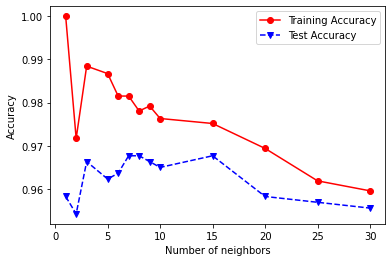

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
%matplotlib inline

numNeighbors = [1, 2, 3, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30]
trainAcc = []
testAcc = []

for k in numNeighbors:
    clf1 = KNeighborsClassifier(n_neighbors=k, metric='minkowski', p=2)
    clf1.fit(X_train, Y_train)
    Y_predTrain = clf1.predict(X_train)
    Y_predTest = clf1.predict(X_test)
    trainAcc.append(accuracy_score(Y_train, Y_predTrain))
    testAcc.append(accuracy_score(Y_test, Y_predTest))

plt.plot(numNeighbors, trainAcc, 'ro-', numNeighbors, testAcc,'bv--')
plt.legend(['Training Accuracy','Test Accuracy'])
plt.xlabel('Number of neighbors')
plt.ylabel('Accuracy')

K=8 is the knee point for both Training and Testing data. Therefore let k=8

Text(0, 0.5, 'Accuracy')

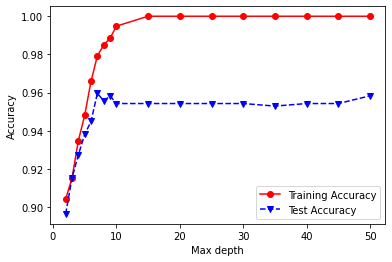

In [ ]:
###########################################################################
# Model fit and performance evaluation for various tree depth from 2-50
###########################################################################
from sklearn.tree import DecisionTreeClassifier
import numpy as np
maxdepths = [2,3,4,5,6,7,8,9,10,15,20,25,30,35,40,45,50]  # 17 different depths

trainAccuracy = np.zeros(len(maxdepths))
testAccuracy = np.zeros(len(maxdepths))

index = 0
for depth in maxdepths:
    clf2 = tree.DecisionTreeClassifier(max_depth=depth)
    clf2 = clf2.fit(X_train, Y_train)
    Y_predTrain = clf2.predict(X_train)
    Y_predTest = clf2.predict(X_test)
    trainAccuracy[index] = accuracy_score(Y_train, Y_predTrain)
    testAccuracy[index] = accuracy_score(Y_test, Y_predTest)
    index += 1
    
###########################################################################
# Plot training and test accuracies
##########################################################################
    
plt.plot(maxdepths,trainAccuracy,'ro-',maxdepths,testAccuracy,'bv--')
plt.legend(['Training Accuracy','Test Accuracy'])
plt.xlabel('Max depth')
plt.ylabel('Accuracy')

Maxdepth=8 is the knee point for Testing data. Therefore let Max_depth=8

WH to write why did not use PCA, cause we need all 5 var.
Justify what we are using by accuracy / text based


In [ ]:
#KNN
